# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [3]:
labels.info()

labels['real_age'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

В датасете содержатся фотографии людей от 1 до 100 лет. Пропуски отсутствуют. Посмотрим на распределение возраста в выборке:

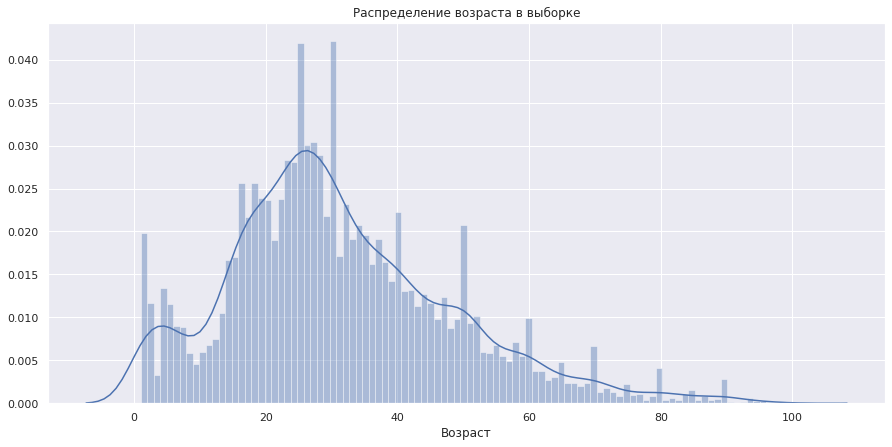

In [4]:
plt.figure(figsize=(15, 7))
sns.set(style="darkgrid")
ax = sns.distplot(labels['real_age'], bins=100)
ax.set_title('Распределение возраста в выборке')
ax.set_xlabel('Возраст')
plt.show()

Из графика видно, что наибольшее количество данных имеется для диапазона 15-40 лет.

С помощью загрузчика ImageDataGenerator извлечём данные из папки с фотографиями:

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [6]:
features, target = next(train_gen_flow)

features.shape

(32, 224, 224, 3)

Выведем на экран 15 изображжений:

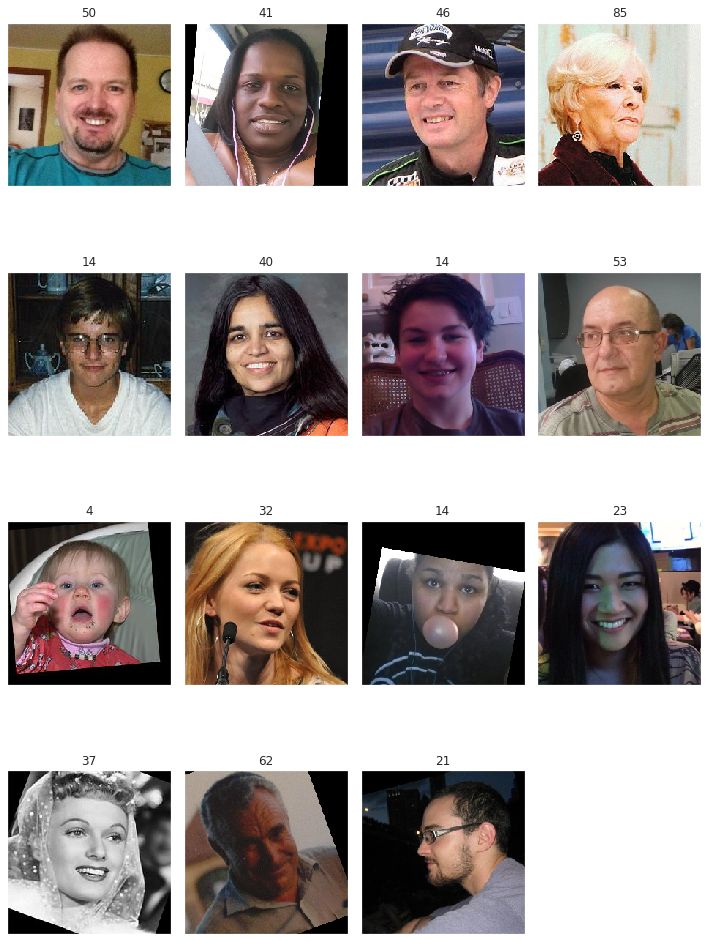

In [8]:
fig = plt.figure(figsize=(10,15))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

### Вывод.
В выборке имеется 7591 фотография. Имеются как цветные, так и чёрно-белые изображения, часть фото со смещением. Для людей старше 60 лет данных сильно меньше. Основной возрастной диапазон: 15-40 лет. Возможно, использование данных для детей младше 5 лет бессмысленно, т.к. маловероятно самостоятельное посещение магазинов и тем более приобретение товаров в таком возрасте, но исключать вероятность не будем.

## Обучение модели

Для обучения модели были использованы вычислительные мощности Yandex.Cloud. Ниже представлен код и результаты обучения. Используемые инструменты указаны в начале тетради.

### Обучение

```python
#функция для загрузки обучающей выборки:

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow

#функция для загрузки тестовой выборки:

def load_test(path):
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255)

    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv('/datasets/faces/labels.csv'),
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_datagen_flow

#функция для создания модели:

def create_model(input_shape):
    
    optimizer = Adam(lr=0.0001)
    
    backbone = ResNet50(input_shape=(224, 224, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                    include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())   
    model.add(Dense(1, activation='relu')) 

    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, metrics=['mae'])
    return model

#функция для обучения модели:

def train_model(model, train_data, test_data, batch_size=None, epochs=6,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data, 
              validation_data=test_data,
              epochs=epochs, batch_size=batch_size,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

### Результаты обучения.

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 44s - loss: 267.0313 - mae: 11.5854 - val_loss: 791.1701 - val_mae: 23.1900
Epoch 2/6
178/178 - 37s - loss: 62.5344 - mae: 6.0516 - val_loss: 615.0434 - val_mae: 19.6696
Epoch 3/6
178/178 - 37s - loss: 32.4615 - mae: 4.3700 - val_loss: 218.9241 - val_mae: 10.8609
Epoch 4/6
178/178 - 36s - loss: 19.6169 - mae: 3.4320 - val_loss: 105.2098 - val_mae: 7.7865
Epoch 5/6
178/178 - 36s - loss: 15.0194 - mae: 2.9971 - val_loss: 84.1331 - val_mae: 7.0642
Epoch 6/6
178/178 - 36s - loss: 12.8204 - mae: 2.7509 - val_loss: 69.8768 - val_mae: 6.3731

60/60 - 9s - loss: 69.8768 - mae: 6.3731
Test MAE: 6.3731

```

### Результаты обучения после применения горизонтального флипа.

```python
#функция для загрузки обучающей выборки:

def load_train(path):
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1/255,
        horizontal_flip=True)
```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.

Train for 178 steps, validate for 60 steps
Epoch 1/6
178/178 - 119s - loss: 234.8815 - mae: 10.9849 - val_loss: 868.2380 - val_mae: 24.5988
Epoch 2/6
178/178 - 37s - loss: 75.1868 - mae: 6.5568 - val_loss: 391.3958 - val_mae: 14.7667
Epoch 3/6
178/178 - 37s - loss: 48.1825 - mae: 5.2743 - val_loss: 209.9180 - val_mae: 10.7352
Epoch 4/6
178/178 - 37s - loss: 35.9583 - mae: 4.5318 - val_loss: 150.3481 - val_mae: 9.1238
Epoch 5/6
178/178 - 37s - loss: 27.0552 - mae: 3.9774 - val_loss: 73.9964 - val_mae: 6.4576
Epoch 6/6
178/178 - 37s - loss: 21.4660 - mae: 3.5193 - val_loss: 74.0580 - val_mae: 6.3387

60/60 - 9s - loss: 74.0580 - mae: 6.3387
Test MAE: 6.3387

```

## Анализ обученной модели

В результате была обучена нейронная сеть на архитектуре ResNet50. Последний слой имеет 1 нейрон и функцию активации ReLU. В качестве алгоритма обучения был использован Adam со скоростью обучения 0,0001. Обучение длилось 6 эпох. В результате MAE на тестовой выборке равно 6,37. Модель с таким значением ошибки можно использовать для определения принадлежности покупателя к возрастной группе (при словии, что диапазон группы 15-20 лет). Но, для контроля продажи алкоголя ошибка в 6 лет недопустима.